In [1]:
# Install a conda package in the current Jupyter kernel
import sys

import string
import gensim
from gensim import corpora, models
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim.models import CoherenceModel
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

import warnings
warnings.filterwarnings('ignore')



# We import sklearn.
import sklearn

import csv
import gc
import pandas as pd
import random
import pickle
import chardet

In [2]:
def uniquify(seq, idfun=None): 
   # order preserving
   if idfun is None:
       def idfun(x): return x
   seen = {}
   result = []
   for item in seq:
       marker = idfun(item)
       if marker in seen: continue
       seen[marker] = 1
       result.append(item)
   return result

In [3]:
from datetime import timedelta, date

years = [7,10,11,12,13,14,15,16]


def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)


dates = {}        
for year in years:
    days = []
    year = year + 2000
    start = date(year, 1, 1)
    end = date(year, 12, 31)
    for dt in daterange(start, end):
        days.append(dt.strftime("%m-%d-%Y"))
    dates[year] = days

In [4]:
docs = []
years = [2007,2010,2011,2012,2013,2014,2015]
BGT_jobID_50 = []

a = 0
for year in years:
    for date in dates[year]:
        a += 1
        date_docs = []
        filename = '../../text_data/JobText_US_' + date + '.txt'
        with open(filename) as file:
            i = 0 
            nums = random.sample(range(1, 10000), 5)
            for line in csv.reader(file, dialect="excel-tab"):
                i += 1
                if line[0] != '' and i in nums:
                    BGT_jobID_50.append(line[1])
                    docs.append(line[3])

In [5]:
stop_words = set(stopwords.words('english'))

In [6]:
# stemmer
p_stemmer = PorterStemmer()

In [7]:
documents = []
bgt_50 = {}

for i in docs:
    # tokenize text
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = [x.lower() for x in tokenizer.tokenize(i)]

    # remove stop words, numbers, and short words from tokens
    stopped_tokens = [i for i in tokens if not i in stop_words and len(i) > 3 and not i.isdigit()]

    # stem and lemmatize tokens
    stemmed_tokens = [p_stemmer.stem(WordNetLemmatizer().lemmatize(i, pos='v')) for i in stopped_tokens]
    
    # add tokens to list
    documents.append(stemmed_tokens)

In [8]:
# pickle documents
docfile = open('documents.pkl', 'wb')
pickle.dump(documents, docfile)

# pickle BGT ID dictionary
idfile = open('bgt_50.pkl', 'wb')
pickle.dump(BGT_jobID_50, idfile)

In [14]:
# turn tokenize documents into a id - term dictionary
#documents = []
dictionary = corpora.Dictionary(documents)

In [10]:
# filter out words that are too frequent or too infrequent
dictionary.filter_extremes(no_below=0.02, no_above=0.5, keep_n=100000)
dictionary.save('dictionary_5')

In [11]:
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(document) for document in documents]
corpora.MmCorpus.serialize('corpus_5.mm', corpus)

In [15]:
# load dictionary, corpus, documents, and IDs
dictionary = dictionary.load('dictionary_5')
corpus = corpora.MmCorpus('corpus_5.mm')

docfile = open('documents.pkl', 'rb')
documents = pickle.load(docfile)

idfile = open('bgt_50.pkl', 'rb')
BGT_jobID_50 = pickle.load(idfile)

In [16]:
# creating object for LDA model
Lda = gensim.models.ldamodel.LdaModel

def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = Lda(corpus, num_topics=num_topics, id2word=dictionary, passes=20)        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print(num_topics)

    return model_list, coherence_values

In [13]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=documents, start=10, limit=51, step=5)

10
15
20
25
30
35
40
45
50


In [14]:
# Can take a long time to run, second half
model_list_2, coherence_values_2 = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=documents, start=55, limit=76, step=5)

55
60
65
70
75


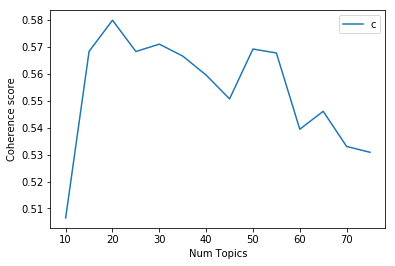

In [15]:
# Show graph
limit=76; start=10; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values + coherence_values_2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [16]:
# Print the coherence scores
for m, cv in zip(x, coherence_values + coherence_values_2):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 10  has Coherence Value of 0.5065
Num Topics = 15  has Coherence Value of 0.5683
Num Topics = 20  has Coherence Value of 0.5799
Num Topics = 25  has Coherence Value of 0.5683
Num Topics = 30  has Coherence Value of 0.571
Num Topics = 35  has Coherence Value of 0.5666
Num Topics = 40  has Coherence Value of 0.5595
Num Topics = 45  has Coherence Value of 0.5507
Num Topics = 50  has Coherence Value of 0.5692
Num Topics = 55  has Coherence Value of 0.5677
Num Topics = 60  has Coherence Value of 0.5394
Num Topics = 65  has Coherence Value of 0.5461
Num Topics = 70  has Coherence Value of 0.533
Num Topics = 75  has Coherence Value of 0.5309


In [106]:
optimal_model = Lda(corpus, num_topics=20, id2word=dictionary, passes=20)        
optimal_model.save("lda_model_5")

In [17]:
num_topics = 20
optimal_model = Lda.load("lda_model_5")
dictionary = dictionary.load('dictionary_5')
corpus = corpora.MmCorpus('corpus_5.mm')

In [107]:
# Visualize the topics
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(optimal_model, corpus, dictionary, mds="tsne")

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
17     -57.978882  115.975403       1        1  14.428905
4     -122.101082  142.402176       2        1  10.874163
12    -162.871857  -54.776989       3        1   9.560296
14    -227.007126  -17.204742       4        1   7.799626
8     -107.682693    3.455535       5        1   7.141753
2       22.913916    8.636256       6        1   7.035986
19     -84.171585  -51.676849       7        1   6.465044
10    -175.509018 -148.029541       8        1   6.288762
3     -197.358414   79.197472       9        1   5.765062
16     151.150696    9.630202      10        1   4.300699
11      62.484581   65.314125      11        1   3.319762
18      54.715370  -55.158211      12        1   3.156754
1     -120.071983 -106.124161      13        1   2.663829
7     -166.822876   14.486029      14        1   2.636955
5     -125.537109   71.372986      15        1   2.353108
9      -62.955612   48.471195      16        1   2.003776
15     -37.189938   -6.472945      17        1   1.543524
6       -3.051754   80.470291      18        1   1.238999
13     -52.427017 -119.950378      19        1   0.824989
0      -12.628206  -67.801643      20        1   0.598004, topic_info=      Category          Freq           Term         Total  loglift  logprob
term                                                                       
442    Default  13054.000000          sales  13054.000000  30.0000  30.0000
270    Default  10856.000000           jobs  10856.000000  29.0000  29.0000
23     Default   8264.000000           care   8264.000000  28.0000  28.0000
735    Default   9293.000000         please   9293.000000  27.0000  27.0000
32     Default  15610.000000        company  15610.000000  26.0000  26.0000
317    Default   4646.000000       security   4646.000000  25.0000  25.0000
40     Default  11528.000000       customer  11528.000000  24.0000  24.0000
298    Default   5854.000000         posted   5854.000000  23.0000  23.0000
517    Default   8163.000000        contact   8163.000000  22.0000  22.0000
678    Default   7566.000000          email   7566.000000  21.0000  21.0000
118    Default  13522.000000           must  13522.000000  20.0000  20.0000
79     Default   6684.000000         health   6684.000000  19.0000  19.0000
244    Default   3856.000000    engineering   3856.000000  18.0000  18.0000
2467   Default   4100.000000          store   4100.000000  17.0000  17.0000
316    Default   5131.000000         search   5131.000000  16.0000  16.0000
22     Default  12113.000000       business  12113.000000  15.0000  15.0000
107    Default  13326.000000     management  13326.000000  14.0000  14.0000
421    Default   3466.000000        patient   3466.000000  13.0000  13.0000
0      Default  12357.000000        ability  12357.000000  12.0000  12.0000
1141   Default   4127.000000      equipment   4127.000000  11.0000  11.0000
87     Default  12503.000000    information  12503.000000  10.0000  10.0000
321    Default  12348.000000       services  12348.000000   9.0000   9.0000
462    Default   2665.000000  careerbuilder   2665.000000   8.0000   8.0000
214    Default   5748.000000    application   5748.000000   7.0000   7.0000
384    Default   6170.000000      customers   6170.000000   6.0000   6.0000
494    Default   9599.000000          apply   9599.000000   5.0000   5.0000
45     Default   4237.000000         design   4237.000000   4.0000   4.0000
320    Default  13242.000000        service  13242.000000   3.0000   3.0000
333    Default   5642.000000        systems   5642.000000   2.0000   2.0000
111    Default   5133.000000        medical   5133.000000   1.0000   1.0000
...        ...           ...            ...           ...      ...      ...
1683   Topic20     60.453518      lancaster     64.058640   5.0614  -5.6599
20785  Topic20    148.201523          naics    170.576370   4.9787  -4.7632
1360   Topic20    220

In [108]:
optimal_model.show_topics(num_topics=20)

[(0,
  '0.018*"dummybgt" + 0.018*"jtext" + 0.013*"occupation" + 0.011*"view" + 0.009*"naics" + 0.008*"none" + 0.007*"lawn" + 0.007*"listings" + 0.007*"specified" + 0.006*"information"'),
 (1,
  '0.047*"please" + 0.042*"contact" + 0.021*"poster" + 0.018*"services" + 0.018*"phone" + 0.016*"must" + 0.016*"compensation" + 0.015*"acirc" + 0.014*"recruiters" + 0.013*"commercial"'),
 (2,
  '0.058*"sales" + 0.023*"customer" + 0.016*"service" + 0.015*"business" + 0.012*"customers" + 0.012*"marketing" + 0.010*"products" + 0.010*"services" + 0.008*"company" + 0.007*"level"'),
 (3,
  '0.017*"company" + 0.016*"career" + 0.015*"opportunity" + 0.014*"benefits" + 0.011*"great" + 0.011*"people" + 0.010*"opportunities" + 0.009*"join" + 0.009*"team" + 0.008*"offer"'),
 (4,
  '0.015*"required" + 0.011*"ability" + 0.009*"duties" + 0.008*"requirements" + 0.008*"procedures" + 0.007*"knowledge" + 0.007*"office" + 0.007*"must" + 0.007*"service" + 0.007*"information"'),
 (5,
  '0.025*"engineering" + 0.022*"main

In [18]:
topics = {}
vectors = []
for i,idx in enumerate(documents):
        # get the topic percentages for each document
        bow = dictionary.doc2bow(idx)
        v = optimal_model.get_document_topics(bow)
        
        # key => value, document number => topic vector
        topics[i] = v
        
        # iterate through the topic vector
        dict = {}
        for j,jdx in enumerate(v):
            # key => value, topic number => percentage of document
            dict[jdx[0]] = jdx[1]

        # give the dictionary the same number of keys as topics, one for each topic
        vector = []
        for k in range(num_topics):
            # if the topic was in the original vector, use the given percentage
            if k in dict.keys():
                vector.append(dict[k])
            # else give the topic the percentage zero
            else:
                vector.append(0)
        # add the vector to the set of document vectors
        vectors.append(np.asarray([vector]))

In [19]:
# pickle vectors
docfile = open('vectors.pkl', 'wb')
pickle.dump(vectors, docfile)

In [20]:
years = ['07','10','11','12','13','14','15']
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
titles = {}

"""Main"""
for year in years:
    for month in months:
        filename = '../Main Text Files/Main 20' + year +'/Main 20' + year + '-'+ month +'.txt'
        with open(filename, encoding='latin-1') as file:
            for line in csv.reader(file, dialect="excel-tab"):
                if line[0] in BGT_jobID_50:
                    titles[line[0]] = line[3]

In [21]:
# pickle titles
docfile = open('titles.pkl', 'wb')
pickle.dump(titles, docfile)

In [4]:
import pickle
titlefile = open('../../titles_7_500.pkl', 'rb')
titles = pickle.load(titlefile)

In [7]:
len(titles)

178524

In [23]:
def top_5_similar(vectors):
    # choose five random job postings
    for j in range(5):
        index = np.random.randint(0,len(titles) - 1)
        
        # find cosine similarity and euclidean distance from the given vector for every other job posting
        cosines = {}
        euclideans = {}
        for i,ind in enumerate(vectors):
            if i != index:
                cosines[sklearn.metrics.pairwise.cosine_similarity(vectors[index],vectors[i])[0][0]] = i
                euclideans[sklearn.metrics.pairwise.euclidean_distances(vectors[index],vectors[i])[0][0]] = i

        # find the 5 highest cosine similarity and 5 shortest euclidean distance
        top_5_cosine = sorted(cosines.keys(), reverse=True)[:6]
        top_5_euclidean = sorted(euclideans.keys())[:6]
        
        # print out the cosine similarities
        print("\nTop 5 cosine similarity to:", titles[BGT_jobID_50[index]])
        for i,indx in enumerate(top_5_cosine):
            print("  ", round(top_5_cosine[i], 3), titles[BGT_jobID_50[cosines[top_5_cosine[i]]]])
            
        # print out the euclidean distances
        print("Lowest 5 euclidean distance from:", titles[BGT_jobID_50[index]])
        for k,inx in enumerate(top_5_euclidean):
            print("  ", round(top_5_euclidean[k], 3), titles[BGT_jobID_50[euclideans[top_5_euclidean[k]]]])

In [24]:
top_5_similar(vectors)


Top 5 cosine similarity to: Speech Language Pathologist
   0.961 Ot Travel - Occupational Therapist In
   0.953 Registered Nurse - Shifts
   0.949 Speech Language Pathologist In
   0.948 Physical Therapist/Pt Snf Setting
   0.946 Allied Health Occupational Therapist
   0.944 Travel Physical Therapist pt - Pediatrics
Lowest 5 euclidean distance from: Speech Language Pathologist
   0.144 Ot Travel - Occupational Therapist In
   0.152 Physical Therapist/Pt Snf Setting
   0.155 Registered Nurse - Shifts
   0.167 Travel Physical Therapist pt - Pediatrics
   0.167 Physical Therapist
   0.169 Occupational Therapist ot - Snf

Top 5 cosine similarity to: Web Developer Q
   0.995 Systems Engineer - Ccna
   0.992 Multimedia Subject Matter Expert With Ts/Sci With Polygraph
   0.989 Software Development Engineer
   0.989 Senior Systems Engineer I Pids
   0.988 Senior lead Java Developer
   0.988 Microwave Engineer
Lowest 5 euclidean distance from: Web Developer Q
   0.088 Multimedia Subject Matter

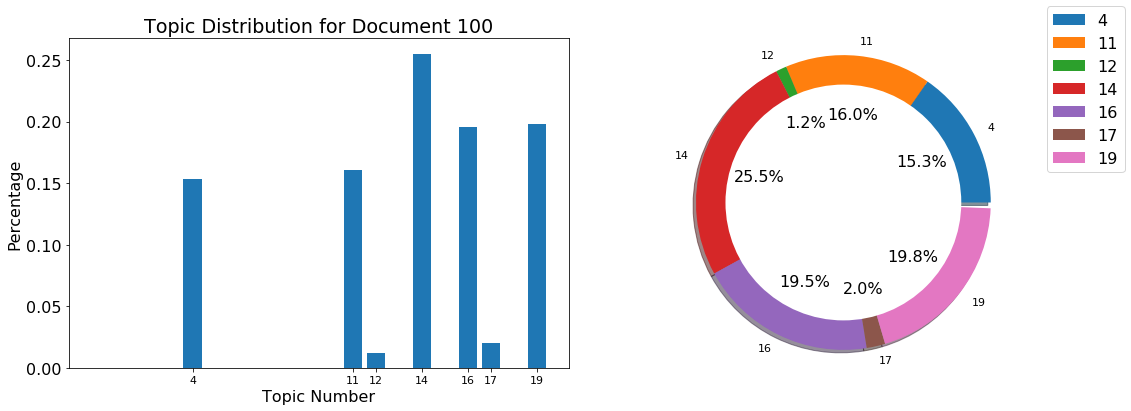

In [27]:
# import matplotlib
import matplotlib.pyplot as plt

doc_num = 100
labels = np.where(vectors[doc_num][0] != 0)[0]
plt.rcParams['figure.figsize'] = (16,6)
plt.rcParams.update({'font.size': 16})
plt.rc('xtick', labelsize=11)    

topics = np.arange(30)

f, (ax1, ax2) = plt.subplots(1, 2)

ax1.bar(range(num_topics), vectors[doc_num][0], align='center')
ax1.set_xticks(labels)
ax1.set_ylabel('Percentage')
ax1.set_xlabel('Topic Number')
ax1.set_title('Topic Distribution for Document ' + str(doc_num))

ax2.pie(vectors[doc_num][0][labels], autopct='%1.1f%%', labels=labels, shadow=True)
plt.legend([topics[i] for i in labels], loc=1, borderaxespad=-2)

#draw circle
centre_circle = plt.Circle((0,0),0.80,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
def top_1000_similar(vectors):
        indices = []
        index = 32535
        cosines = {}
        for i,ind in enumerate(vectors):
            if i != index:
                cosines[sklearn.metrics.pairwise.cosine_similarity(vectors[index],vectors[i])[0][0]] = i

        top_1000_cosine = sorted(cosines.keys(), reverse=True)[:1001]
        print("\nTop 1000 cosine similarity to:", titles[index])
        for i,ind in enumerate(top_1000_cosine):
            print("  ", round(ind, 3), titles[cosines[ind]])
            indices.append(cosines[ind])
            
        return indices

indices = top_1000_similar(vectors)